TODO:
 - ~~Move the parameter information above all other plotted lines~~
 - Find small cutoff scale for density/vel profiles
    - Idea: Make it the mass of ~30 particles
    - Need a way to make it for vels, though

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import glob
import sys
sys.path.append('../../py/')

from cosmoSim import cosmoSim

In [2]:
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)
matplotlib.rcParams['font.size']=10

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rc('text', usetex=True)

ALPHA=0.8

FIG_HEIGHT = 11 / 2
FIG_WIDTH = 8.5

FIGSIZE=[FIG_WIDTH,FIG_HEIGHT]
DPI=300

snap_ranges = [
    [5, 4],
    [3, 2]
    ]

zz_color = 'b'
m2m2_color = 'g'
cdm_color = 'r'
zz_dm_color = 'tab:cyan'
m2m2_dm_color = 'tab:olive'
cdm_dm_color = 'tab:pink'

In [3]:
outpath = '../../plots/plots_L3N256/grid/'

try:
    os.mkdir(outpath)
except:
    print(f'{outpath} already exists!')


# CDM_runs = ['run_CDM_L3N256_HY']

# CDM_DM_runs = [ f'run_CDM_L3N256_DM_dir_{i}' for i in range(10) ] + ['run_CDM_L3N256_DM']

# tcDM_runs1 = [ f'run_2cDM_L3N256_HY_power00_sigma1_dir_{i}' for i in range(10) ] + ['run_2cDM_L3N256_HY_power00_sigma1']

# tcDM_DM_runs1 = [ f'run_2cDM_L3N256_DM_power00_sigma1_dir_{i}' for i in range(10) ] + ['run_2cDM_L3N256_DM_power00_sigma1']

#tcDM_runs2 = ['run_2cDM_L3N256_HY_powerm2m2_sigma1']

tcDM_DM_runs2 = [ f'run_2cDM_L3N256_DM_powerm2m2_sigma1_dir_{i}' for i in range(10) ]


CDM_runs = [ f'run_CDM_L3N256_HY_dir_{i}' for i in range(10) ] + ['run_CDM_L3N256_HY']

CDM_DM_runs = [ f'run_CDM_L3N256_DM_dir_{i}' for i in range(10) ] + ['run_CDM_L3N256_DM']

tcDM_runs1 = [ f'run_2cDM_L3N256_HY_power00_sigma1_dir_{i}' for i in range(10) ] + ['run_2cDM_L3N256_HY_power00_sigma1']

tcDM_DM_runs1 = [ f'run_2cDM_L3N256_DM_power00_sigma1_dir_{i}' for i in range(10) ] + ['run_2cDM_L3N256_DM_power00_sigma1']

tcDM_runs2 = [ f'run_2cDM_L3N256_HY_powerm2m2_sigma1_dir_{i}' for i in range(10) ] + ['run_2cDM_L3N256_HY_powerm2m2_sigma1']

tcDM_DM_runs2 = [ f'run_2cDM_L3N256_DM_powerm2m2_sigma1_dir_{i}' for i in range(10) ]

../../plots/plots_L3N256/grid/ already exists!


In [4]:
def wnumber2wlength(k):
    return 1/k
def wlength2wnumber(l):
    return 1/l    

In [5]:
def get_samples(domain, interpf_list):
    return [ interpf(domain) for interpf in interpf_list ]

def get_dk_averages(run_list, redshift):
    run = cosmoSim(run_list[0])
    lims, pk_interp, dk_interp, k_ny =  run.interp_combined_power_spectra(redshift, omegaM=0.301712, omegaB=0.046026, debug=True)
    inf = lims[0]
    sup = lims[1]

    interps = []

    for run_n in run_list:
        run = cosmoSim(run_n)
        lims, pk_interp, interp, k_ny =  run.interp_combined_power_spectra(redshift, omegaM=0.301712, omegaB=0.046026, debug=True)
        interps.append(interp)
        if lims[0] > inf: inf = lims[0]
        if lims[1] < sup: sup = lims[1]

    return (inf, sup), interps

def get_hmf_averages(run_list, redshift):
    run = cosmoSim(run_list[0])
    lims, interp =  run.interp_mass_profile(redshift)
    inf = lims[0]
    sup = lims[1]

    interps = []

    for run_n in run_list:
        run = cosmoSim(run_n)
        lims, interp =  run.interp_mass_profile(redshift)
        interps.append(interp)
        if lims[0] > inf: inf = lims[0]
        if lims[1] < sup: sup = lims[1]

    return (inf, sup), interps

def get_cvf_averages(run_list, redshift):
    run = cosmoSim(run_list[0])
    lims, interp =  run.interp_vels_profile(redshift)
    inf = lims[0]
    sup = lims[1]

    interps = []

    for run_n in run_list:
        run = cosmoSim(run_n)
        lims, interp =  run.interp_vels_profile(redshift)
        interps.append(interp)
        if lims[0] > inf: inf = lims[0]
        if lims[1] < sup: sup = lims[1]

    return (inf, sup), interps

def calculate_averages(domain, interps):
    samps = get_samples(domain, interps)
    avg = np.mean(samps, axis=0)
    ten = np.percentile(samps, 10, axis=0)
    ninety = np.percentile(samps, 90, axis=0)

    return avg, ten, ninety

def calculate_ratios(domain, interps_numerator, interps_denominator):
    samps_numerator = get_samples(domain, interps_numerator)
    samps_denominator = get_samples(domain, interps_denominator)

    samps = [ num / den for num, den in zip(samps_numerator, samps_denominator) ]
    avg = np.mean(samps, axis=0)
    ten = np.percentile(samps, 10, axis=0)
    ninety = np.percentile(samps, 90, axis=0)

    return avg, ten, ninety


def get_averages(CDM_runs, tcDM_runs, redshift, function='dk', ratios=False):

    if function == 'dk':
        get_avg_func = get_dk_averages
    elif function == 'mass':
        get_avg_func = get_hmf_averages
    elif function == 'velocity':
        get_avg_func = get_cvf_averages

    clims, CDM_interps = get_avg_func(CDM_runs, redshift)
    tlims, tcDM_interps = get_avg_func(tcDM_runs, redshift)

    inf = clims[0] if clims[0] > tlims[0] else tlims[0]
    sup = clims[1] if clims[1] < tlims[1] else tlims[1]

    domain = np.geomspace(inf, sup, num=1000)

    if ratios:
        ratio_samps, ratios_ten, ratios_ninety = calculate_ratios(domain, tcDM_interps, CDM_interps)
        return domain, (ratio_samps, ratios_ten, ratios_ninety)
    else:
        CDM_avg, CDM_ten, CDM_ninety = calculate_averages(domain, CDM_interps)
        tcDM_avg, tcDM_ten, tcDM_ninety = calculate_averages(domain, tcDM_interps)

        return domain, (CDM_avg, CDM_ten, CDM_ninety), (tcDM_avg, tcDM_ten, tcDM_ninety)

In [6]:
def profile_inner(fig, axes, function, zz, m2m2, ratio=False):
    if function == 'mass':
        fig.supxlabel("Halo Mass ($M_{\odot}$)")
        if ratio:
            fig.supylabel("$N_{2cDM}\\left(>M\\right)/N_{CDM}\\left(>M\\right)$")
        else:
            fig.supylabel("$N\\left(>M\\right)$")
    elif function == 'velocity':
        fig.supxlabel("$V_{max}$ [km s$^{-1}$]")
        if ratio:
            fig.supylabel("$N_{2cDM}\\left(>V\\right)/N_{CDM}\\left(>V\\right)$")
        else:
            fig.supylabel("$N\\left(>V\\right)$")

    ax = axes[-1, -1]
    #print(ax.get_xticks())

    if function == 'mass': ax.set_xticks(ax.get_xticks()[3:])

    if zz:
        ax.plot([],[], label='2cDM [0, 0]', color=zz_color)
    if m2m2:
        ax.plot([],[], label='2cDM [-2, -2]', color=m2m2_color)

    if not ratio: ax.plot([],[], label='CDM', color=cdm_color)

    ax.plot([],[], label='Hydro', color='k')
    ax.plot([],[], label='N-Body', color='k', linestyle='dashed')
    ax.legend()

    if function == 'mass':
        for a in axes[:, -1]:
            a.set_xlim(10**6, 10**11)

    fig.tight_layout()

def the_profile_plotting(redshift_ranges, function, zz=False, m2m2=False, save=False):
    fig = plt.figure(figsize=FIGSIZE)
    gs = fig.add_gridspec(len(snap_ranges), len(snap_ranges[0]), hspace=0, wspace=0)
    axes = gs.subplots(sharex='col', sharey='row')
    for i, redshift_range in enumerate(redshift_ranges):
        for j, redshift in enumerate(redshift_range):
            ax = axes[i]

            tcDM_runs = tcDM_runs1
            tcDM_DM_runs = tcDM_DM_runs1

            bins, (CDM_avg, CDM_ten, CDM_ninety), (tcDM_avg, tcDM_ten, tcDM_ninety) = get_averages(CDM_runs, tcDM_runs, redshift, function=function)
            ax[j].plot(bins, CDM_avg, alpha=ALPHA, color=cdm_color)
            ax[j].fill_between(bins, CDM_ten, CDM_ninety, alpha=0.5*ALPHA, color=cdm_color)

            ax[j].plot(bins, tcDM_avg, alpha=ALPHA, color=zz_color)
            ax[j].fill_between(bins, tcDM_ten, tcDM_ninety, alpha=0.5*ALPHA, color=zz_color)

            bins, (CDM_avg, CDM_ten, CDM_ninety), (tcDM_avg, tcDM_ten, tcDM_ninety) = get_averages(CDM_DM_runs, tcDM_DM_runs, redshift, function=function)
            ax[j].plot(bins, CDM_avg, alpha=ALPHA, color=cdm_color, linestyle='dashed')
            ax[j].fill_between(bins, CDM_ten, CDM_ninety, alpha=0.25*ALPHA, color=cdm_dm_color)
            ax[j].plot(bins, tcDM_avg, alpha=ALPHA, color=zz_color, linestyle='dashed')
            ax[j].fill_between(bins, tcDM_ten, tcDM_ninety, alpha=0.25*ALPHA, color=zz_dm_color)

            tcDM_runs = tcDM_runs2
            tcDM_DM_runs = tcDM_DM_runs2

            try:
                bins, _, (tcDM_avg, tcDM_ten, tcDM_ninety) = get_averages(CDM_runs, tcDM_runs, redshift, function=function)
                ax[j].plot(bins, tcDM_avg, alpha=ALPHA, color=m2m2_color)
                ax[j].fill_between(bins, tcDM_ten, tcDM_ninety, alpha=0.5*ALPHA, color=m2m2_color)
            except:
                pass

            bins, _, (tcDM_avg, tcDM_ten, tcDM_ninety) = get_averages(CDM_DM_runs, tcDM_DM_runs, redshift, function=function)
            ax[j].plot(bins, tcDM_avg, alpha=ALPHA, color=m2m2_color, linestyle='dashed')
            ax[j].fill_between(bins, tcDM_ten, tcDM_ninety, alpha=0.25*ALPHA, color=m2m2_dm_color)
            r_nearest = cosmoSim(CDM_runs[0]).get_nearest_redshift(redshift)
            for a in ax:
                a.set_yscale("log")
                a.set_xscale("log")
                if function == 'mass':
                    a.set_xlim(10**6, 10**11)
                if function == 'velocity':
                    a.set_xlim(2, 10**2)
                a.grid(True, which="both", ls="-")
                a.set_aspect( 'auto', adjustable='box' )
            ax[j].plot([],[], label='z = {}'.format(r_nearest), alpha=0)
            ax[j].legend()
    profile_inner(fig, axes, function, zz, m2m2)
    fname = outpath + f'grid_{function}_profiles'
    if zz: fname += '_with00'
    if m2m2: fname += '_withm2m2'
    fname += '.pdf'
    if save: plt.savefig(fname, dpi=DPI, bbox_inches='tight')
    plt.show()

def the_profile_ratio_plotting(redshift_ranges, function, zz=False, m2m2=False, save=False):
    fig = plt.figure(figsize=FIGSIZE)
    gs = fig.add_gridspec(len(snap_ranges), len(snap_ranges[0]), hspace=0, wspace=0)
    axes = gs.subplots(sharex='col', sharey='row')
    for i, redshift_range in enumerate(redshift_ranges):
        for j, redshift in enumerate(redshift_range):
            ax = axes[i]

            tcDM_runs = tcDM_runs1
            tcDM_DM_runs = tcDM_DM_runs1

            bins, (ratio_avg, ratio_ten, ratio_ninety) = get_averages(CDM_runs, tcDM_runs, redshift, function=function, ratios=True)

            ax[j].plot(bins, ratio_avg, alpha=ALPHA, color=zz_color)
            ax[j].fill_between(bins, ratio_ten, ratio_ninety, alpha=0.5*ALPHA, color=zz_color)

            bins, (ratio_avg, ratio_ten, ratio_ninety) = get_averages(CDM_DM_runs, tcDM_DM_runs, redshift, function=function, ratios=True)

            ax[j].plot(bins, ratio_avg, alpha=ALPHA, color=zz_color,  linestyle='dashed')
            ax[j].fill_between(bins, ratio_ten, ratio_ninety, alpha=0.25*ALPHA, color=zz_dm_color)

            tcDM_runs = tcDM_runs2
            tcDM_DM_runs = tcDM_DM_runs2

            try:
                bins, (ratio_avg, ratio_ten, ratio_ninety) = get_averages(CDM_runs, tcDM_runs, redshift, function=function, ratios=True)
                ax[j].plot(bins, ratio_avg, alpha=ALPHA, color=m2m2_color)
                ax[j].fill_between(bins, ratio_ten, ratio_ninety, alpha=0.5*ALPHA, color=m2m2_color)
            except:
                pass

            bins, (ratio_avg, ratio_ten, ratio_ninety) = get_averages(CDM_DM_runs, tcDM_DM_runs, redshift, function=function, ratios=True)
            ax[j].fill_between(bins, ratio_ten, ratio_ninety, alpha=0.25*ALPHA, color=m2m2_dm_color)

            ax[j].plot(bins, ratio_avg, alpha=ALPHA, color=m2m2_color,  linestyle='dashed')
            r_nearest = cosmoSim(CDM_runs[0]).get_nearest_redshift(redshift)
            for a in ax:
                a.set_xscale("log")
                if function == 'mass':
                    a.set_xlim(10**6, 10**11)
                if function == 'velocity':
                    a.set_xlim(2, 10**2)
                a.grid(True, which="both", ls="-")
                a.set_ylim(0, 1.5)
                a.set_aspect( 'auto', adjustable='box' )

            ax[j].plot([],[], label='z = {}'.format(r_nearest), alpha=0)
            ax[j].legend()

    profile_inner(fig, axes, function, zz, m2m2, ratio=True)
    fname = outpath + f'grid_{function}_profiles_ratios'
    if zz: fname += '_with00'
    if m2m2: fname += '_withm2m2'
    fname += '.pdf'
    if save: plt.savefig(fname, dpi=DPI, bbox_inches='tight')
    plt.show()

../../py\cosmoSim.py:104: UserWarning: WARNING: Requested redshift 5 is not within tolerance 0.1 of snapshot redshift 5.24!
  warnings.warn(f"WARNING: Requested redshift {redshift} is not within tolerance {tolerance} of snapshot redshift {self.redshifts[idx]}!")
../../py\cosmoSim.py:54: UserWarning: Vkick not explicitly set! Assuming 100 km/s...
  warnings.warn('Vkick not explicitly set! Assuming 100 km/s...')


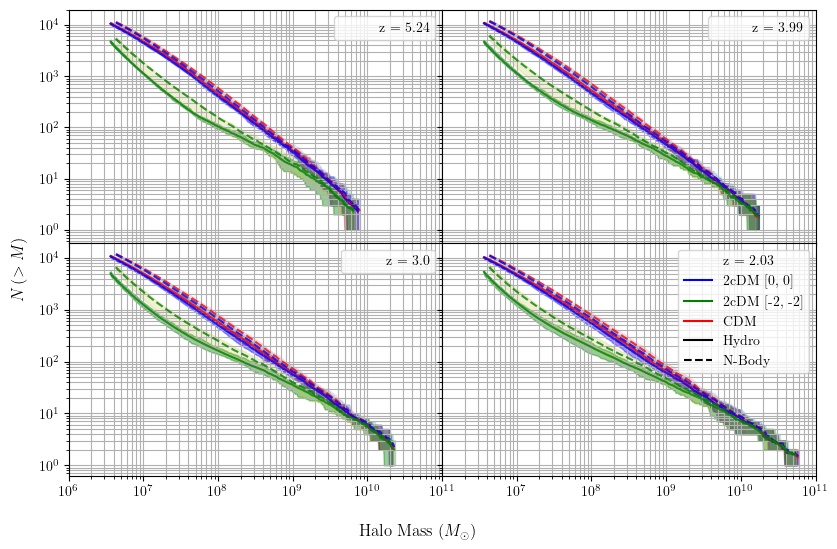

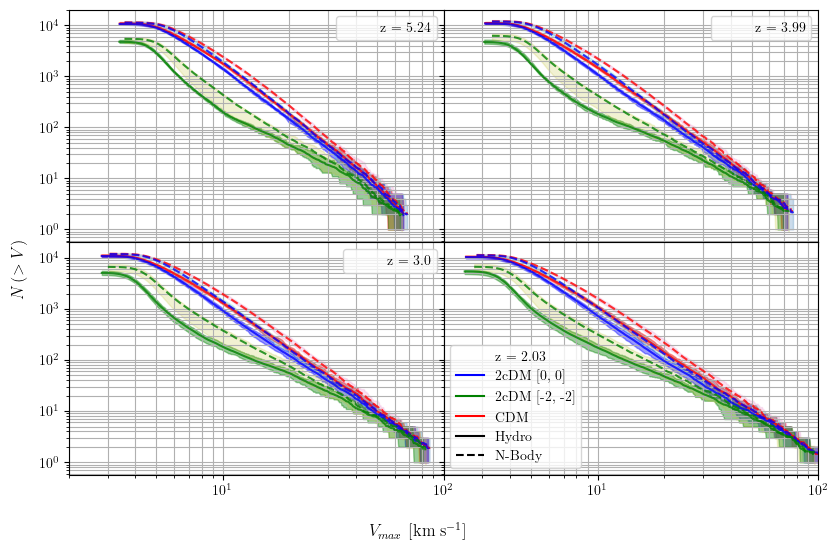

In [7]:
the_profile_plotting(snap_ranges, 'mass', zz=True, m2m2=True, save=True)
the_profile_plotting(snap_ranges, 'velocity', zz=True, m2m2=True, save=True)

c:\Users\ryanm\.conda\envs\paperI\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true_divide
c:\Users\ryanm\.conda\envs\paperI\lib\site-packages\numpy\lib\function_base.py:4011: RuntimeWarning: invalid value encountered in multiply
  lerp_interpolation = asanyarray(add(a, diff_b_a*t, out=out))


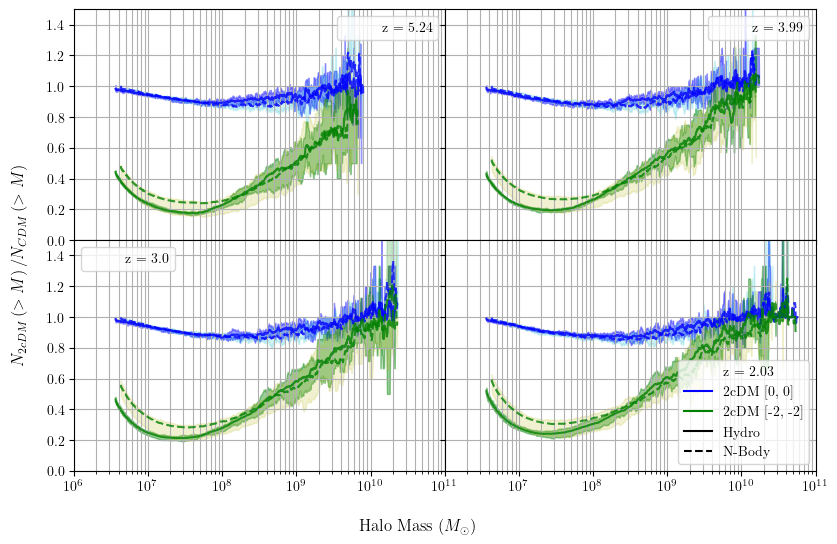

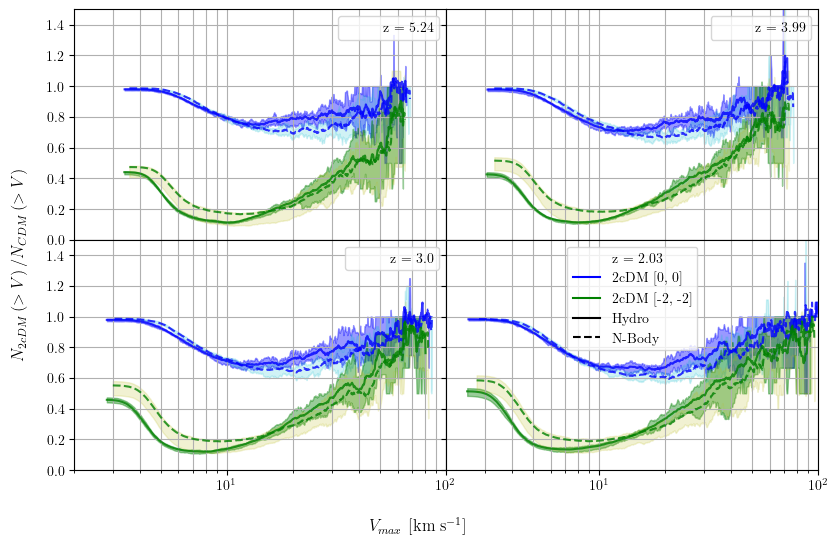

In [8]:
the_profile_ratio_plotting(snap_ranges, 'mass', zz=True, m2m2=True, save=True)
the_profile_ratio_plotting(snap_ranges, 'velocity', zz=True, m2m2=True, save=True)

In [9]:
def power_spectra_inner(fig, axes, k_ny, zz, m2m2, ratio=False):
    fig.supxlabel('k [$h$ Mpc$^{-1}$]')
    if ratio:
        fig.supylabel('$P_{2cDM}/P_{CDM}$')
    else:
        fig.supylabel('$\Delta^{2}(k)$')

    for i, a in enumerate(axes[0]):
        sax = a.secondary_xaxis('top', functions=(wnumber2wlength, wlength2wnumber))

    sax.set_xticks([1e-3, 1e-2, 1e-1])

    ax = axes[0,0]
    topax = inset_axes(ax, # here using axis of the lowest plot
            height="5%",  # width = 5% of parent_bbox width
            width="200%",  # height : 340% good for a (4x4) Grid
            loc='upper right',
            bbox_to_anchor=(1.05, 0.3, 1, 1),
            bbox_transform=ax.transAxes,
            borderpad=0,
            )
    topax.set_xticks([])
    topax.set_yticks([])
    [topax.spines[side].set_visible(False) for side in ('left', 'top', 'right', 'bottom')]
    topax.patch.set_visible(False)
    topax.set_xlabel('$\lambda$ [Mpc $h^{-1}$]')
    topax.tick_params(top=True)

    ax = axes[-1, -1]

    ax.set_xticks([1e1, 1e2, 1e3])

    if zz:
        ax.plot([],[], label='2cDM [0, 0]', color=zz_color)
    if m2m2:
        ax.plot([],[], label='2cDM [-2, -2]', color=m2m2_color)

    if not ratio: ax.plot([],[], label='CDM', color=cdm_color)

    if ratio:
        ax.text(10**2, 0.2, '$k_{Nyquist}$')
    else:
        ax.text(k_ny + 0.5*10**2, 10**6 + 2*10**5, '$k_{Nyquist}$')
    ax.plot([],[], label='Hydro', color='k')
    ax.plot([],[], label='N-Body', color='k', linestyle='dashed')
    ax.legend()

    fig.tight_layout()

def the_power_spectra_plotting(redshift_ranges, zz=False, m2m2=False, save=False):
    fig = plt.figure(figsize=FIGSIZE)
    gs = fig.add_gridspec(len(snap_ranges), len(snap_ranges[0]), hspace=0, wspace=0)
    axes = gs.subplots(sharex='col', sharey='row')
    for i, redshift_range in enumerate(redshift_ranges):
        for j, redshift in enumerate(redshift_range):
            ax = axes[i]

            tcDM_runs = tcDM_runs1
            tcDM_DM_runs = tcDM_DM_runs1

            bins, (CDM_avg, CDM_ten, CDM_ninety), (tcDM_avg, tcDM_ten, tcDM_ninety) = get_averages(CDM_runs, tcDM_runs, redshift, function='dk')
            ax[j].plot(bins, CDM_avg, alpha=ALPHA, color=cdm_color)
            ax[j].fill_between(bins, CDM_ten, CDM_ninety, alpha=0.5*ALPHA, color=cdm_color)

            ax[j].plot(bins, tcDM_avg, alpha=ALPHA, color=zz_color)
            ax[j].fill_between(bins, tcDM_ten, tcDM_ninety, alpha=0.5*ALPHA, color=zz_color)

            bins, (CDM_avg, CDM_ten, CDM_ninety), (tcDM_avg, tcDM_ten, tcDM_ninety) = get_averages(CDM_DM_runs, tcDM_DM_runs, redshift, function='dk')
            ax[j].plot(bins, CDM_avg, alpha=ALPHA, color=cdm_color, linestyle='dashed')
            ax[j].fill_between(bins, CDM_ten, CDM_ninety, alpha=0.25*ALPHA, color=cdm_dm_color)
            ax[j].plot(bins, tcDM_avg, alpha=ALPHA, color=zz_color, linestyle='dashed')
            ax[j].fill_between(bins, tcDM_ten, tcDM_ninety, alpha=0.25*ALPHA, color=zz_dm_color)

            tcDM_runs = tcDM_runs2
            tcDM_DM_runs = tcDM_DM_runs2
            try:
                bins, _, (tcDM_avg, tcDM_ten, tcDM_ninety) = get_averages(CDM_runs, tcDM_runs, redshift, function='dk')
                ax[j].plot(bins, tcDM_avg, alpha=ALPHA, color=m2m2_color)
                ax[j].fill_between(bins, tcDM_ten, tcDM_ninety, alpha=0.5*ALPHA, color=m2m2_color)
            except:
                pass
            bins, _, (tcDM_avg, tcDM_ten, tcDM_ninety) = get_averages(CDM_DM_runs, tcDM_DM_runs, redshift, function='dk')
            ax[j].plot(bins, tcDM_avg, alpha=ALPHA, color=m2m2_color, linestyle='dashed')
            ax[j].fill_between(bins, tcDM_ten, tcDM_ninety, alpha=0.25*ALPHA, color=m2m2_dm_color)

            k_ny = cosmoSim(tcDM_DM_runs[0]).load_power_spectra(redshift)[-1]
            ax[j].vlines(k_ny, 10**0, 10**8, colors='m', linestyles='dashed')
            r_nearest = cosmoSim(CDM_runs[0]).get_nearest_redshift(redshift)
            for a in ax:
                a.set_yscale("log")
                a.set_xscale("log")
                a.set_xlim(10**0, 10**3)
                a.set_ylim(10**0, 10**7 + 2*10**7)
                a.grid(True, which="both", ls="-")
                a.set_aspect( 'auto', adjustable='box' )
            ax[j].plot([],[], label='z = {}'.format(r_nearest), alpha=0)
            ax[j].legend()

    power_spectra_inner(fig, axes, k_ny, zz, m2m2)
    fname = outpath + f'grid_power_spectra'
    if zz: fname += '_with00'
    if m2m2: fname += '_withm2m2'
    fname += '.pdf'
    if save: plt.savefig(fname, dpi=DPI, bbox_inches='tight')
    plt.show()

def the_power_spectra_ratio_plotting(redshift_ranges, zz=False, m2m2=False, save=False):
    fig = plt.figure(figsize=FIGSIZE)
    gs = fig.add_gridspec(len(snap_ranges), len(snap_ranges[0]), hspace=0, wspace=0)
    axes = gs.subplots(sharex='col', sharey='row')
    for i, redshift_range in enumerate(redshift_ranges):
        for j, redshift in enumerate(redshift_range):
            ax = axes[i]

            tcDM_runs = tcDM_runs1
            tcDM_DM_runs = tcDM_DM_runs1

            bins, (ratio_avg, ratio_ten, ratio_ninety) = get_averages(CDM_runs, tcDM_runs, redshift, function='dk', ratios=True)

            ax[j].plot(bins, ratio_avg, alpha=ALPHA, color=zz_color)
            ax[j].fill_between(bins, ratio_ten, ratio_ninety, alpha=0.5*ALPHA, color=zz_color)

            bins, (ratio_avg, ratio_ten, ratio_ninety) = get_averages(CDM_DM_runs, tcDM_DM_runs, redshift, function='dk', ratios=True)

            ax[j].plot(bins, ratio_avg, alpha=ALPHA, color=zz_color,  linestyle='dashed')
            ax[j].fill_between(bins, ratio_ten, ratio_ninety, alpha=0.25*ALPHA, color=zz_dm_color)

            tcDM_runs = tcDM_runs2
            tcDM_DM_runs = tcDM_DM_runs2

            try:
                bins, (ratio_avg, ratio_ten, ratio_ninety) = get_averages(CDM_runs, tcDM_runs, redshift, function='dk', ratios=True)
                ax[j].plot(bins, ratio_avg, alpha=ALPHA, color=m2m2_color)
                ax[j].fill_between(bins, ratio_ten, ratio_ninety, alpha=0.5*ALPHA, color=m2m2_color)
            except:
                pass

            bins, (ratio_avg, ratio_ten, ratio_ninety) = get_averages(CDM_DM_runs, tcDM_DM_runs, redshift, function='dk', ratios=True)

            ax[j].plot(bins, ratio_avg, alpha=ALPHA, color=m2m2_color,  linestyle='dashed')
            ax[j].fill_between(bins, ratio_ten, ratio_ninety, alpha=0.25*ALPHA, color=m2m2_dm_color)

            k_ny = cosmoSim(tcDM_DM_runs[0]).load_power_spectra(redshift)[-1]
            ax[j].vlines(k_ny, -3, 3, colors='m', linestyles='dashed')
            r_nearest = cosmoSim(CDM_runs[0]).get_nearest_redshift(redshift)
            for a in ax:
                a.set_xscale('log')
                a.set_xlim(10**0, 10**3)
                a.set_ylim(0, 1.3)
                a.grid(True, which="both", ls="-")
                a.set_aspect( 'auto', adjustable='box' )

            ax[j].plot([],[], label='z = {}'.format(r_nearest), alpha=0)
            ax[j].legend()

    power_spectra_inner(fig, axes, k_ny, zz, m2m2, ratio=True)
    fname = outpath + f'grid_power_spectra_ratios'
    if zz: fname += '_with00'
    if m2m2: fname += '_withm2m2'
    fname += '.pdf'
    if save: plt.savefig(fname, dpi=DPI, bbox_inches='tight')
    plt.show()

c:\Users\ryanm\.conda\envs\paperI\lib\site-packages\ipykernel_launcher.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
c:\Users\ryanm\.conda\envs\paperI\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


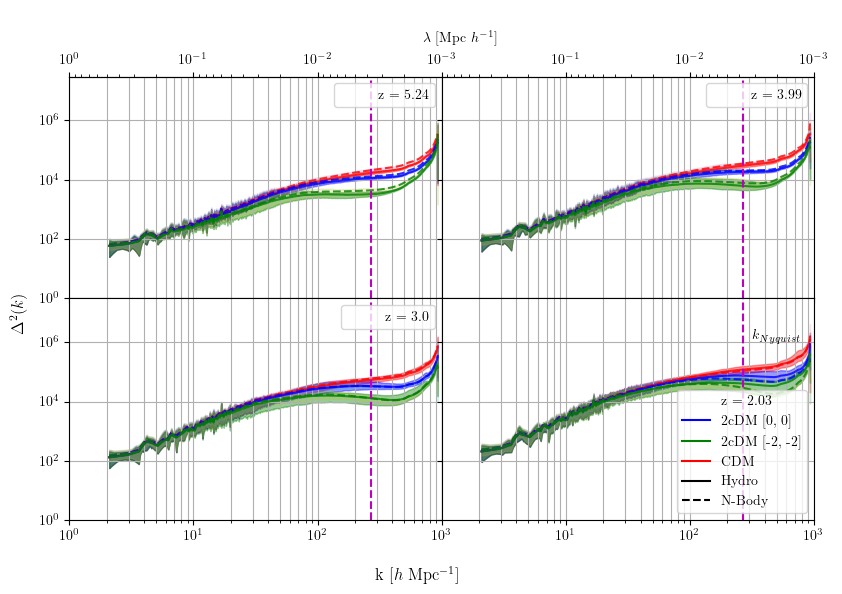

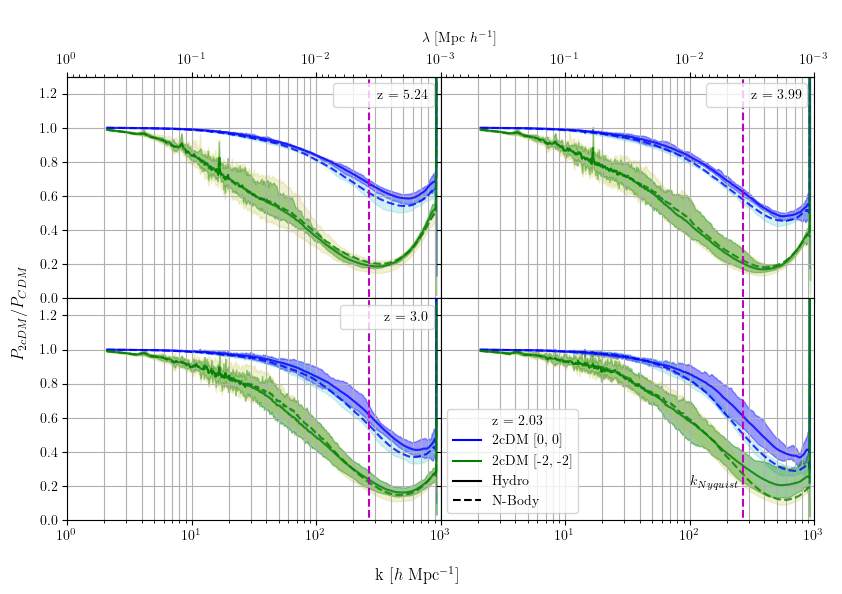

In [10]:
the_power_spectra_plotting(snap_ranges, zz=True, m2m2=True, save=True)
the_power_spectra_ratio_plotting(snap_ranges, zz=True, m2m2=True, save=True)